In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from matplotlib import figure as fig

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Henry_Hub_Natural_Gas_Spot_Price.csv to Henry_Hub_Natural_Gas_Spot_Price.csv


In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Henry_Hub_Natural_Gas_Spot_Price.csv']))
df['Date'] = pd.to_datetime(df['Date'])
spot_price = df
spot_price = spot_price.set_index(spot_price.columns[0])
spot_price

,price
Date,
2022-12-12,6.73
2022-12-09,4.98
2022-12-08,4.79
2022-12-07,4.49
2022-12-06,4.58
...,...
1997-01-13,4.00
1997-01-10,3.92
1997-01-09,3.61


Historical Spot price visualization:


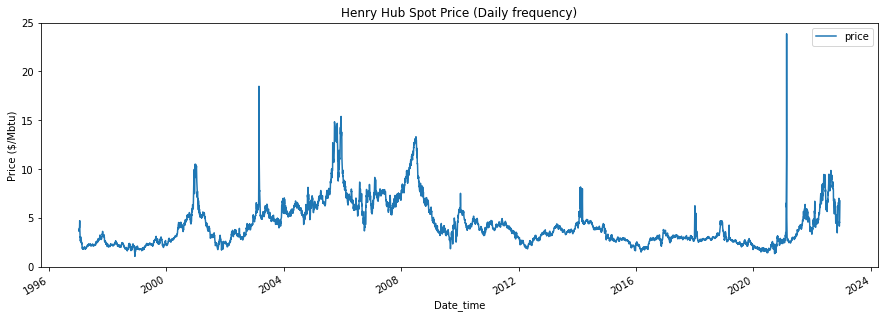

In [4]:
print('Historical Spot price visualization:')
spot_price.plot(figsize = (15,5), title = 'Henry Hub Spot Price (Daily frequency)')
plt.xlabel ('Date_time')
plt.ylabel ('Price ($/Mbtu)')
plt.show()

In [5]:
print('Missing values:', spot_price.isnull().sum().sum()) 


# checking missing values
spot_price = spot_price.dropna() 


# dropping missing valies
print('....Dropped Missing value row....\n')

# checking missing values
print('Rechecking Missing values:', spot_price.isnull().sum()) 


Missing values: 1
....Dropped Missing value row....

Rechecking Missing values: price    0
dtype: int64


In [6]:
spot_price.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,6517.0,4.236109,2.198055,1.05,2.69,3.6,5.33,23.86


Box plot Visualization


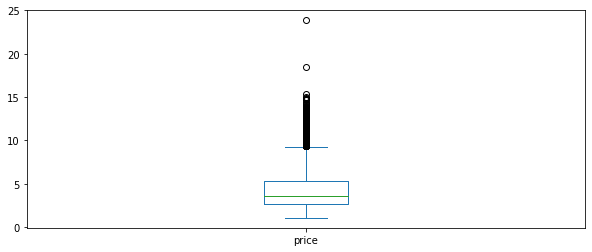

In [7]:
# Generate Boxplot
print("Box plot Visualization")
spot_price.plot(kind = "box", figsize = (10, 4))
plt.show()

Histogram Visualization:


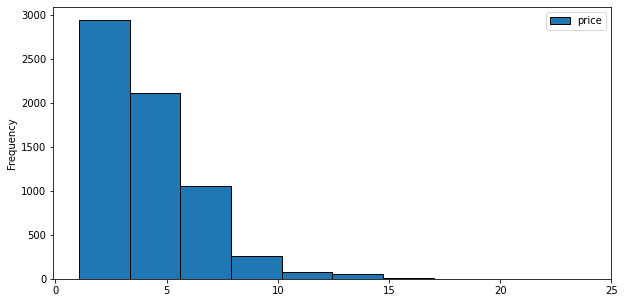

In [8]:
# Generate Histogram
print( "Histogram Visualization:")
spot_price.plot( kind = "hist", edgecolor = "black", figsize = (10,5))
plt.show()

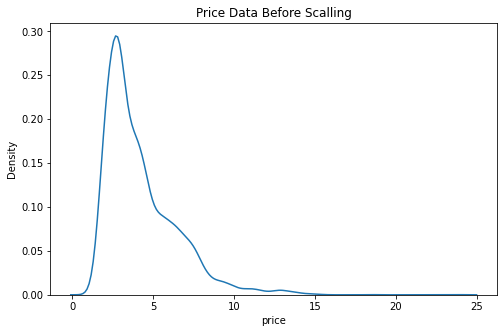

In [9]:
import seaborn as sns
fig, ax1 = plt.subplots(ncols = 1, figsize = (8,5))
ax1.set_title("Price Data Before Scalling")
sns.kdeplot(spot_price["price"], ax = ax1 )
plt.show()

In [10]:
train_size = int(len(spot_price) * 0.95)
test_size = len(spot_price) - train_size
train, test = spot_price.iloc[0:train_size], spot_price.iloc[train_size:len(spot_price)]
print ("Train Shape:", train.shape)
print("Test shape:", test.shape)

Train Shape: (6191, 1)
Test shape: (326, 1)


In [11]:
# Data Standardization
robust = RobustScaler(quantile_range = (25, 75)).fit(train[["price"]])
train["price"] = robust.transform(train[["price"]])
test["price"] = robust.transform(test[["price"]])

<ipython-input-11-2ec1c4785d42>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["price"] = robust.transform(train[["price"]])
<ipython-input-11-2ec1c4785d42>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["price"] = robust.transform(test[["price"]])


In [12]:
#helper function
def create_dataset(X, y, time_steps=1):
    a, b = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)]
        a.append(v)
        b.append(y.iloc[i + time_steps])
    return np.array(a), np.array(b)

    # Now we will create sequences with 30 days of historical Data
n_steps = 30

# reshape to 3D [n_samples, n_steps, n_features]
X_train, y_train = create_dataset(train[["price"]], train["price"],n_steps)
X_test, y_test = create_dataset(test[["price"]], test['price'], n_steps)

print ("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (6161, 30, 1)
X_test shape: (296, 30, 1)


In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
tf.keras.layers.RepeatVector(1)


In [14]:
units = 64
dropout = 0.20
optimizer = "adam"
loss = 'mae'
epochs = 50

model = keras.Sequential()
model.add(keras.layers.LSTM(units = units, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=dropout))
model.add(tf.keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units = units, return_sequences = True))
model.add(keras.layers.Dropout(rate=dropout))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss = loss, optimizer = optimizer)
history = model.fit(X_train, y_train, epochs = epochs, batch_size = 32, validation_split = 0.1, shuffle = False)

Epoch 1/50
174/174 [==============================] - 9s 32ms/step - loss: 0.2344 - val_loss: 0.1118
Epoch 2/50
174/174 [==============================] - 5s 31ms/step - loss: 0.1953 - val_loss: 0.0982
Epoch 3/50
174/174 [==============================] - 5s 28ms/step - loss: 0.1827 - val_loss: 0.1080
Epoch 4/50
174/174 [==============================] - 5s 31ms/step - loss: 0.1772 - val_loss: 0.1165
Epoch 5/50
174/174 [==============================] - 5s 28ms/step - loss: 0.1732 - val_loss: 0.1186
Epoch 6/50
174/174 [==============================] - 5s 29ms/step - loss: 0.1707 - val_loss: 0.1170
Epoch 7/50
174/174 [==============================] - 5s 29ms/step - loss: 0.1710 - val_loss: 0.1134
Epoch 8/50
174/174 [==============================] - 5s 28ms/step - loss: 0.1696 - val_loss: 0.1055
Epoch 9/50
174/174 [==============================] - 5s 31ms/step - loss: 0.1713 - val_loss: 0.0921
Epoch 10/50
174/174 [==============================] - 5s 28ms/step - loss: 0.1666 - val_lo

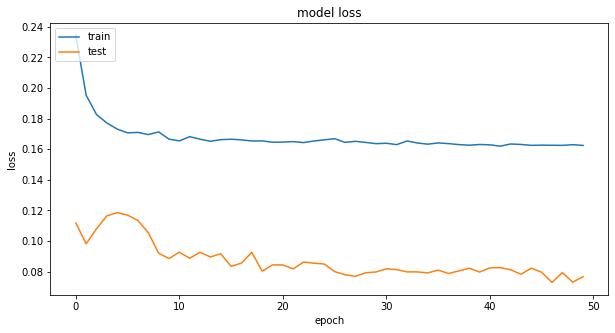

In [15]:
#history for loss

plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

193/193 [==============================] - 3s 9ms/step
Training loss: 0.1702889824696554



<Figure size 720x360 with 0 Axes>

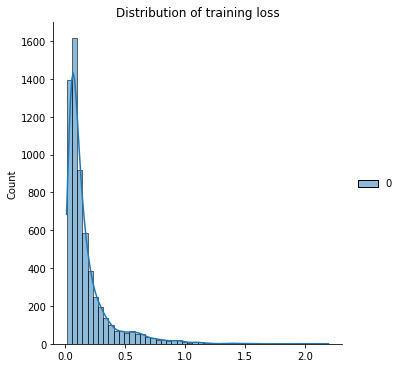

In [16]:
train_pred = model.predict(X_train)
train_loss = (np.mean(np.abs(train_pred - X_train), axis = 1))
avg_loss = train_loss.mean()
print("Training loss:", avg_loss), print()

plt.figure(figsize = (10, 5))
sns.displot(train_loss, bins = 50, kde = True)
plt.title('Distribution of training loss')
plt.show()

193/193 [==============================] - 2s 10ms/step


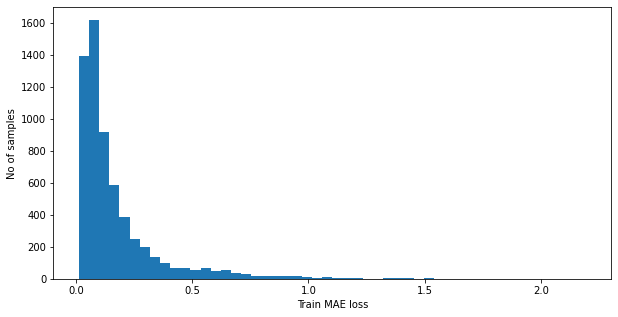

In [17]:
# Get train MAE loss.
train_pred = model.predict(X_train)
train_loss = np.mean(np.abs(train_pred - X_train), axis=1)

plt.figure(figsize = (10,5))
plt.hist(train_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [18]:
# Get reconstruction loss threshold.
threshold = np.max(train_loss)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  2.194930380163572


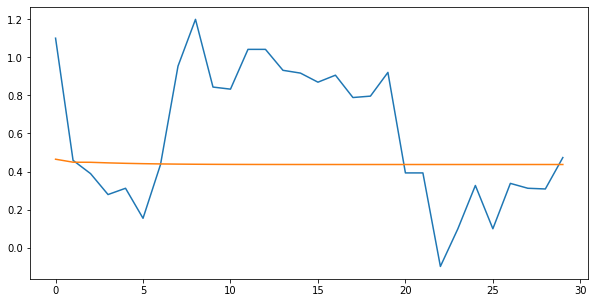

In [19]:
"""### Compare recontruction
Let's see how our model has recontructed the first sample. 
"""

# Checking how the first sequence is learnt
plt.figure(figsize = (10,5))
plt.plot(X_train[0])
plt.plot(train_pred[0])
plt.show()


In [20]:
import math
from sklearn.metrics import mean_squared_error
from pandas import DataFrame

# MAE on the test data:
y_pred = model.predict(X_test)
print('Predict shape:', y_pred.shape); print();
mae = np.mean(np.abs(y_pred - X_test), axis=1)

10/10 [==============================] - 0s 11ms/step
Predict shape: (296, 30, 1)



In [21]:
# reshaping prediction
pred = y_pred.reshape((y_pred.shape[0] * y_pred.shape[1]), y_pred.shape[2])
print('Prediction:', pred.shape); print();
print('Test data shape:', X_test.shape); print();


Prediction: (8880, 1)

Test data shape: (296, 30, 1)



In [22]:
# reshaping test data
X_test = X_test.reshape((X_test.shape[0] * X_test.shape[1]), X_test.shape[2])
print('Test data:', X_test.shape); print();

#Error Computation (To be solve)
errors = X_test - pred
print("Error:", errors.shape), print()


Test data: (8880, 1)

Error: (8880, 1)



(None, None)

In [23]:
#rmse on Test Data
RMSE = math.sqrt(mean_squared_error(X_test, pred))
print('Test RMSE: %.3f' % RMSE);

Test RMSE: 0.128


In [24]:
# Threshould Computation 
dist = np.linalg.norm(X_test - pred, axis=1)
scores = dist.copy()
print('Score:', scores.shape)
scores.sort()
cut_off = int(0.80 * len(scores))
print('Cutoff value:', cut_off)
threshold = scores[cut_off]
print('Threshold value:', threshold) 


Score: (8880,)
Cutoff value: 7104
Threshold value: 0.13102627894200303


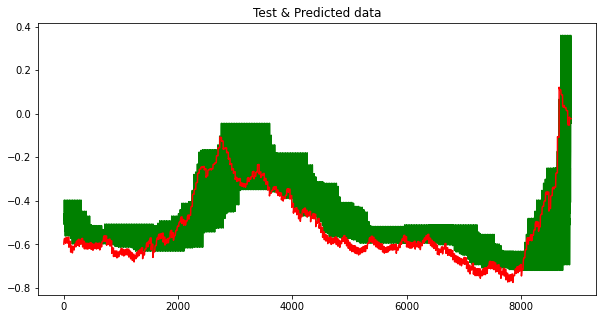

In [25]:
plt.figure(figsize= (10,5))
plt.plot(X_test, color = 'green')
plt.plot(pred, color = 'red')
plt.title("Test & Predicted data")
plt.show()

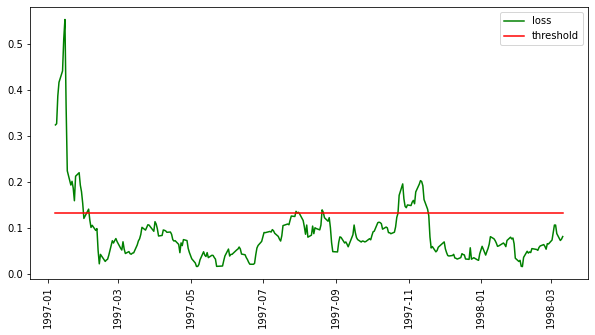

In [26]:
score = DataFrame(index=test[n_steps:].index)
score['loss'] = mae
score['threshold'] = threshold
score['anomaly'] = score['loss'] > score['threshold']
score['price'] = test[n_steps:].price

plt.figure(figsize = (10,5))
plt.plot(score.index, score['loss'], color = 'green', label='loss')
plt.plot(score.index, score['threshold'], color = 'r', label='threshold')
plt.xticks(rotation=90)
plt.legend();

In [27]:
#Anomalies Report Format
anomalies = score[score['anomaly'] == True]
x = DataFrame(anomalies.price)
x = DataFrame(robust.inverse_transform(x))
x.index = anomalies.index
x.rename(columns = {0: 'inverse_price'}, inplace = True)
anomalies = anomalies.join(x, how = 'left')
anomalies = anomalies.drop(columns=['price'], axis=1)
anomalies.tail(10) 


,loss,threshold,anomaly,inverse_price
Date,,,,
1997-01-20,0.192713,0.131026,True,3.26
1997-01-17,0.223576,0.131026,True,3.91
1997-01-16,0.364670,0.131026,True,4.71
1997-01-15,0.552491,0.131026,True,4.34
1997-01-14,0.509403,0.131026,True,4.01
1997-01-13,0.440657,0.131026,True,4.00
1997-01-10,0.416010,0.131026,True,3.92
1997-01-09,0.386219,0.131026,True,3.61
1997-01-08,0.325969,0.131026,True,3.80


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


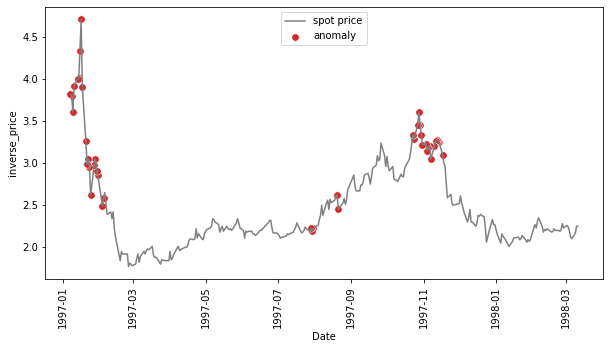

In [28]:
test[n_steps:].index

test_inv = DataFrame(robust.inverse_transform(test[n_steps:]))
test_inv.index = test[n_steps:].index
test_inv.rename(columns = {0: 'price'}, inplace = True)
test_inv

plt.figure(figsize = (10,5))
plt.plot(test_inv.index, test_inv.price, color = 'gray', label='spot price');
sns.scatterplot(anomalies.index, anomalies['inverse_price'], color=sns.color_palette()[3], s=55, label='anomaly')
plt.xticks(rotation=90)
plt.legend(loc='upper center');

In [29]:
#Inverse Test Data:
test_inv = DataFrame(robust.inverse_transform(test[n_steps:]))
test_inv.index = test[n_steps:].index
test_inv.rename(columns = {0: 'price'}, inplace = True)
test_inv 

,price
Date,
1998-03-11,2.25
1998-03-10,2.25
1998-03-09,2.17
1998-03-06,2.10
1998-03-05,2.12
...,...
1997-01-13,4.00
1997-01-10,3.92
1997-01-09,3.61


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


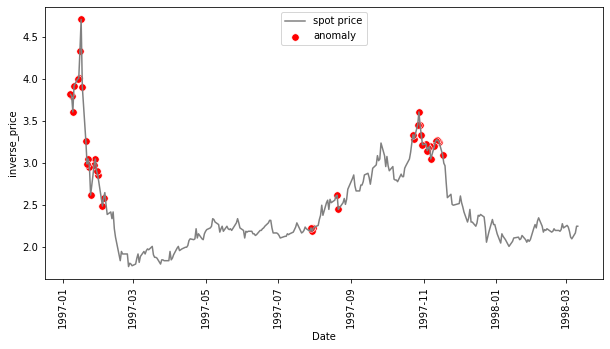

In [30]:
#Anomalies found in testing Data:
plt.figure(figsize = (10,5))
plt.plot(test_inv.index, test_inv.price, color = 'gray', label='spot price')
sns.scatterplot(anomalies.index, anomalies['inverse_price'], color='red', s=55, label='anomaly')
plt.xticks(rotation=90)
plt.legend(loc='upper center') 

